### Combinatorial Computational Geometry

Also called *algorithmic geometry*, the applications of this field are plenty: in robotics, these are used to solve visibility problems, and motion planning, for instance.  Similar applications are employed to design route planning or search algorithms in *geographic information systems* (*GIS*).  

Let us describe the different categories of problems, making emphasis on the tools for solving them that are available in the `scipy` stack.

#### Static Problems

The fundamental problems in this category are the following:

* *Convex hulls*:  Given a set of points in space, find the smallest convex polyhedron containing them.
* *Voronoi diagrams*:  Given a set of points in space (the _seeds_), compute a partition in regions consisting of all points closer to each seed.
* *Triangulations*:  Partition the plane with triangles, in a way that two triangles are either disjoint, or otherwise they share an edge or a vertex.  There are different triangulations depending on the input objects, or constraints on the properties of the triangles.
* *Shortest paths*: Given a set of obstacles in a space, and two points, find the shortest path between the points that does not intersect any of the obstacles.

> The problems of computation of convex hulls, basic triangulations, and Voronoi diagrams are intimately linked.  The theory that explains this beautiful topic is explained in detail in a monograph in Computer Science titled _Computational Geometry_, written by Franco Preparata and Michael Shamos.  It was published by Springer-Verlag in 1985.


##### Convex Hulls

While it is possible to compute the convex hull of a reasonably large set of points in the plane through the geometry module of the library `sympy`, this is not recommendable.  A much faster and reliable code is available in the module `scipy.spatial` through the routine `ConvexHull`, which is in turn a wrapper to `qconvex`, from the `Qhull` libraries (www.qhull.org).  This routine also allows the computation of convex hulls in higher dimensions.   Let us compare both methods, with the famous *Lake Superior* polygon, `superior.poly`.

> `poly` files represent *planar straight line graphs*---a simple list of vertices and edges, together with information about holes and concavities, in some cases.  The running example can be downloaded from www.math.sc.edu/~blanco/superior.poly.  It contains a polygonal description of the coastline of Lake Superior, with 7 holes (for the islands), 518 vertices, and 518 edges.

> For a complete description of the `poly` format, refer to www.cs.cmu.edu/~quake/triangle.poly.html.  With that information, we can write  a simple reader without much effort.  This is an example:


In [1]:
import numpy as np, matplotlib.pyplot as plt
from sympy.geometry import Point, convex_hull
from scipy.spatial import ConvexHull

%matplotlib inline

def read_poly(file_name):
    """
    Simple poly-file reader, that creates a python dictionary 
    with information about vertices, edges and holes.
    It assumes that vertices have no attributes or boundary markers.
    It assumes that edges have no boundary markers.
    No regional attributes or area constraints are parsed.
    """
    
    output = {'vertices': None, 'holes': None, 'segments': None}

    # open file and store lines in a list
    file = open(file_name, 'r')
    lines = file.readlines()
    file.close()
    lines = [x.strip('\n').split() for x in lines]

    # Store vertices
    vertices= []
    N_vertices, dimension, attr, bdry_markers = [int(x) for x in lines[0]]
    # We assume attr = bdrt_markers = 0
    for k in range(N_vertices):
        label, x, y = [items for items in lines[k+1]]
        vertices.append([float(x), float(y)])
        
    output['vertices'] = np.array(vertices)

    # Store segments
    segments = []
    N_segments, bdry_markers = [int(x) for x in lines[N_vertices+1]]
    for k in range(N_segments):
        label, pointer_1, pointer_2 = [items for items in lines[N_vertices+k+2]]
        segments.append([int(pointer_1)-1, int(pointer_2)-1])

    output['segments'] = np.array(segments)

    # Store holes
    N_holes = int(lines[N_segments+N_vertices+2][0])
    holes = []
    for k in range(N_holes):
        label, x, y = [items for items in lines[N_segments + N_vertices + 3 + k]]
        holes.append([float(x), float(y)])

    output['holes'] = np.array(holes)

    return output

We need to be advised: loading each vertex as `Point`, as well as computing the convex hull with that structure, requires far too many resources and time.  Note the difference.

In [2]:
lake_superior = read_poly("superior.poly")

vertices_ls = lake_superior['vertices']

%time hull = ConvexHull(vertices_ls)

CPU times: user 353 µs, sys: 127 µs, total: 480 µs
Wall time: 401 µs


In [3]:
vertices_sympy = [Point(x) for x in vertices_ls]

%time convex_hull(*vertices_sympy)

CPU times: user 240 ms, sys: 808 µs, total: 240 ms
Wall time: 240 ms


Polygon(Point(1/10, -629607/1000000), Point(102293/1000000, -635353/1000000), Point(2773/25000, -643967/1000000), Point(222987/1000000, -665233/1000000), Point(8283/12500, -34727/50000), Point(886787/1000000, -1373/2000), Point(890227/1000000, -6819/10000), Point(9/10, -30819/50000), Point(842533/1000000, -458913/1000000), Point(683333/1000000, -17141/50000), Point(16911/25000, -340427/1000000), Point(654027/1000000, -333047/1000000), Point(522413/1000000, -15273/50000), Point(498853/1000000, -307193/1000000), Point(5977/25000, -25733/50000), Point(273/2500, -619833/1000000))

Let us produce a diagram with the solution, using the computations of `scipy.spatial.ConvexHull`.

> Plotting a set of vertices together with its convex hull in two dimensions (once computed with `ConvexHull`) is also possible with the simple command `convex_hull_plot_2d`.  It requires `matplotlib.pyplot`.

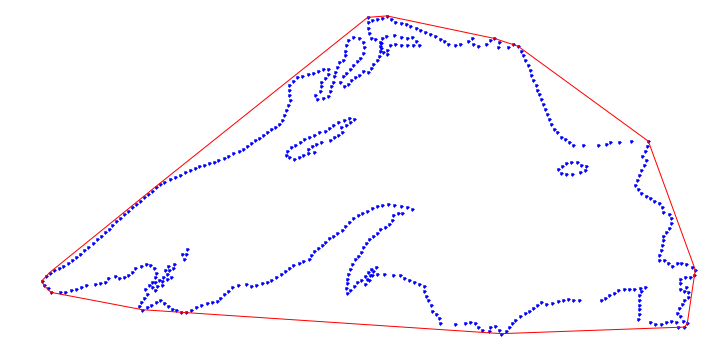

In [4]:
plt.figure(figsize=(12,6))
plt.xlim(vertices_ls[:,0].min()-0.01, vertices_ls[:,0].max()+0.01)
plt.ylim(vertices_ls[:,1].min()-0.01, vertices_ls[:,1].max()+0.01)
plt.axis('off')
plt.axes().set_aspect('equal')
plt.plot(vertices_ls[:,0], vertices_ls[:,1], 'b.')

for simplex in hull.simplices:
    plt.plot(vertices_ls[simplex, 0], vertices_ls[simplex, 1], 'r-')

plt.show()

To modify the output of `ConvexHull`, we are allowed to pass all required `qconvex` controls through the parameter `qhull_options`.  For a list of all `qconvex` controls and other output options, read the `Qhull` manual at www.qhull.org/html/index.htm.  In this chapter, we are content with showing the results obtained with the defaul controls: `qhull_options='Qx Qt'` if the dimension of the points is greater than 4, and `qhull_options='Qt'` otherwise.

Let us now illustrate a few advanced uses of `ConvexHull`.  First, the computation of the convex hull of a random set of points in the 3D space.  For visualization, we will use the `mayavi` libraries.

In [5]:
points = np.random.rand(320, 3)

hull = ConvexHull(points)

X = hull.points[:, 0]
Y = hull.points[:, 1]
Z = hull.points[:, 2]

from mayavi import mlab

mlab.triangular_mesh(X, Y, X, hull.simplices, colormap='gray', opacity=0.5, representation='wireframe')

<img src="3dhull.png">

##### Voronoi Diagrams

Computing the Voronoi diagram of a set of vertices (our _seeds_) can be done with the routine `Voronoi` (and its companion `voronoi_plot_2d` for visualization) from the module `scipy.spatial`.  The routine `Voronoi` is in turn a wrapper to the function `qvoronoi`  from the `Qhull` libraries, with the following default `qvoronoi` controls: `qhull_option='Qbb Qc Qz Qx'` if the dimension of the points is greater than 4, and `qhull_options='Qbb Qc Qz'` otherwise.  For the computation of the *furthest-site Voronoi diagram*, instead of the nearest-site, we would use the extra control `Qu`.

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(vertices_ls)

To understand the output, it is very illustrative to replicate the diagram that we obtain by restricting the visualization obtained by `voronoi_plot_2d` in a small window, centered somewhere in the North shore of Lake Superior.

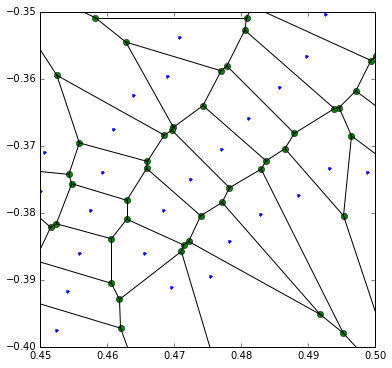

In [7]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111, aspect='equal')
voronoi_plot_2d(vor, ax=ax)
plt.xlim( 0.45,  0.50)
plt.ylim(-0.40, -0.35)
plt.show()

* The small dots are the original seeds with `x`-coordinates between `0.45` and `0.50`, and `y`-coordinates between `-0.40` and `-0.35`.  We access those values either from the original list `vertices_ls`, or from `vor.points`. 
* The plane gets partitioned into different regions (the Voronoi cells), one for each seed.  These regions contain all points in the plane which are closest to its seed.  Each region receives an index, which is not necessarily the same index as the index of its seed in the `vor.points` list.  To access the corresponding region to a given seed, we use `vor.point_region`.  

In [8]:
vor.point_region

array([  0,  22,  24,  21,  92,  89,  91,  98,  97,  26, 218, 219, 220,
       217, 336, 224, 334, 332, 335, 324, 226, 231, 230, 453, 500, 454,
       235, 234, 333, 236, 341, 340,  93, 343, 339, 342, 237, 327, 412,
       413, 344, 337, 338, 138,  67, 272, 408, 404, 403, 407, 406, 405,
       268, 269, 270, 257, 271, 258, 259,   2, 260, 261, 263,  15,  70,
        72, 278, 275, 277, 276, 179, 273, 274, 204, 289, 285, 288, 318,
       317, 216, 215, 312, 313, 309, 310, 243, 151, 150, 364, 365, 244,
       433, 362, 360, 363, 361, 242, 308, 307, 314, 311, 316, 315, 319,
       284, 287, 286, 452, 451, 450, 482, 483, 409, 493, 486, 485, 484,
       510, 516, 517, 410, 494, 518, 512, 515, 511, 513, 514, 508, 509,
       487, 214, 488, 489, 432, 429, 431, 430, 359, 490, 491, 492, 144,
       146, 147, 145, 149, 148, 143, 140, 142, 139, 141, 463, 428, 357,
       427, 462, 459, 461, 460, 426, 240, 239, 241, 352, 356, 355, 421,
       423, 424, 420, 422,  46,  47,  48, 112,  33,  32,  31, 11

* Each Voronoi cell is defined by its delimiting vertices and edges (also known as _ridges_ in Voronoi jargon).  The list with the coordinates of the computed vertices of the Voronoi diagram can be obtained with `vor.vertices`.  These vertices were represented as bigger dots in the previous image, and are easily identifiable because they are always at the intersection of at least two edges --- while the seeds have no incoming edges.

In [9]:
vor.vertices

array([[ 0.88382749, -0.23508215],
       [ 0.10607886, -0.63051169],
       [ 0.03091439, -0.55536174],
       ..., 
       [ 0.49834202, -0.62265786],
       [ 0.50247159, -0.61971784],
       [ 0.5028735 , -0.62003065]])

* For each of the regions, we can access the set of delimiting vertices with `vor.regions`.  For instance, to obtain the coordinates of the vertices that delimit the region around the 4th seed, we could issue

In [10]:
[vor.vertices[x] for x in vor.regions[vor.point_region[4]]]

[array([ 0.13930793, -0.81205929]),
 array([ 0.11638   , -0.92111088]),
 array([ 0.11638   , -0.63657789]),
 array([ 0.11862537, -0.6303235 ]),
 array([ 0.12364332, -0.62893576]),
 array([ 0.12405738, -0.62891987])]

Care must be taken with the previous step: Some of the vertices of the Voronoi cells are not actual vertices, but lie _at infinity_.  When this is the case, they are identified with the index `-1`.  In this situation, to provide an accurate representation of a ridge of these characteristics we must use the knowledge of the two seeds whose contiguous Voronoi cells intersect on said ridge---since the ridge is perpendicular to the segment defined by those two seeds.  We obtain the information about those seeds with `vor.ridge_points`

In [11]:
vor.ridge_points

array([[  0,   1],
       [  0, 433],
       [  0, 434],
       ..., 
       [124, 118],
       [118, 119],
       [119, 122]], dtype=int32)

The first entry of `vor.ridge_points` can be read as follows: There is a ridge perpendicular to both the first and second seeds. 

There are other attributes of the object `vor` that we may use to inquire properties of the Voronoi diagram, but the ones we have described should be enough to replicate the previous image.  We leave this as a nice exercise:  

1. Gather the indices of the seeds from `vor.points` that have their `x`- and `y`-coordinates in the required window.  Plot them.
2. For each of those seeds, gather information about vertices of their corresponding Voronoi cells.  Plot those vertices not at the infity with a different style as the seeds.
3. Gather information about the ridges of each relevant region, and plot them as simple thin segments.  Some of the ridges cannot be represented by their two vertices.  In that case, we use the information about the seeds that determine them.

##### Triangulations

A *triangulation* of a set of vertices in the plane is a division of the convex hull of the vertices into triangles, satisfying one important condition.  Any two given triangles:

* must be disjoint, or
* must intersect only at one common vertex, or
* must share one common edge.

These plain triangulations have not much computational value, since some of its triangles might be too skinny --- this leads to uncomfortable rounding errors, or computation or erroneous areas, centers, etc.  Among all possible triangulations, we always seek one where the properties of the triangles are somehow balanced.

With this purpose in mind, we have the *Delaunay triangulation* of a set of vertices.  This triangulation satisfies an extra condition: None of the vertices lies in the interior of the circumcircle of any triangle.  We refer to triangles with this property as *Delaunay triangles*.

For this simpler setting, in the module `scipy.spatial`, we have the routine `Delaunay`, which is in turn a wrapper to the function `qdelaunay` from the `Qhull` libraries, with the `qdelaunay` controls set exactly as for the Voronoi diagram computations.

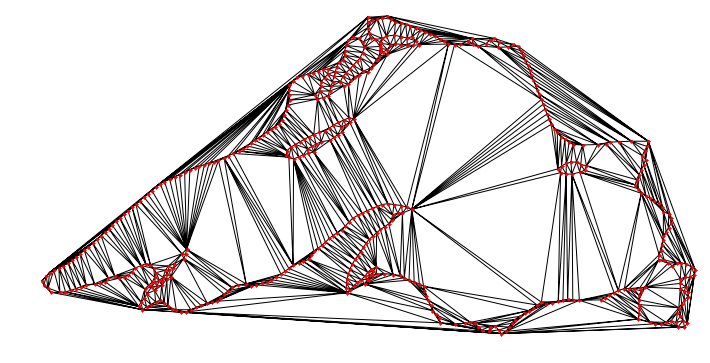

In [12]:
from scipy.spatial import Delaunay

tri = Delaunay(vertices_ls)

plt.figure(figsize=(12,6))
plt.xlim(vertices_ls[:,0].min()-0.01, vertices_ls[:,0].max()+0.01)
plt.ylim(vertices_ls[:,1].min()-0.01, vertices_ls[:,1].max()+0.01)
plt.axes().set_aspect('equal')
plt.axis('off')
plt.triplot(vertices_ls[:,0], vertices_ls[:,1], tri.simplices, 'k-')
plt.plot(vertices_ls[:,0], vertices_ls[:,1], 'r.')
plt.show()

It is possible to generate triangulations with imposed edges too.  Given a collection of vertices and edges, a *constrained Delaunay triangulation* is a division of the space into triangles with those prescribed features.  The triangles in this triangulation are not necessarily Delaunay.

We can accomplish this extra condition sometimes by subdivision of each of the imposed edges.  We call this triangulation *conforming Delaunay*, and the new (artificial) vertices needed to subdivide the edges are called *Steiner points*.

A *constrained conforming Delaunay triangulation* of an imposed set of vertices and edges satisfies a few more conditions, usually setting thresholds on the values of angles or areas of the triangles.  This is achieved by introducing a new set of *Steiner points*, which are allowed anywhere, not only on edges.

> To achieve these high-level triangulations, we need to step outside of the `scipy` stack.  We have a `python` wrapper to the amazing implementation of mesh generators `triangle` by Richard Shewchuck (www.cs.cmu.edu/~quake/triangle.html).  This wrapper, together with examples and other related functions, can be installed by issuing either


>        % easy_install triangle

> or


>        % pip install triangle

> It can also be built from source:

>        % git clone https://github.com/drufat/triangle.git
>        % cd triangle
>        % python setup.py install

> For more information on this module, refer to the documentation online from its author, Dzhelil Rufat, at dzhelil.info/triangle/index.html

Let us compute those different triangulations for our running example.  We use once again the `poly` file with the features of Lake Superior, which we read into a dictionary with all the information about vertices, segments and holes. 	The first example is that of the constrained Delaunay triangulation (`cndt`).  We accomplish this task with the flag `p` (indicating that the source is a _planar straight line graph_, rather than a set of vertices).

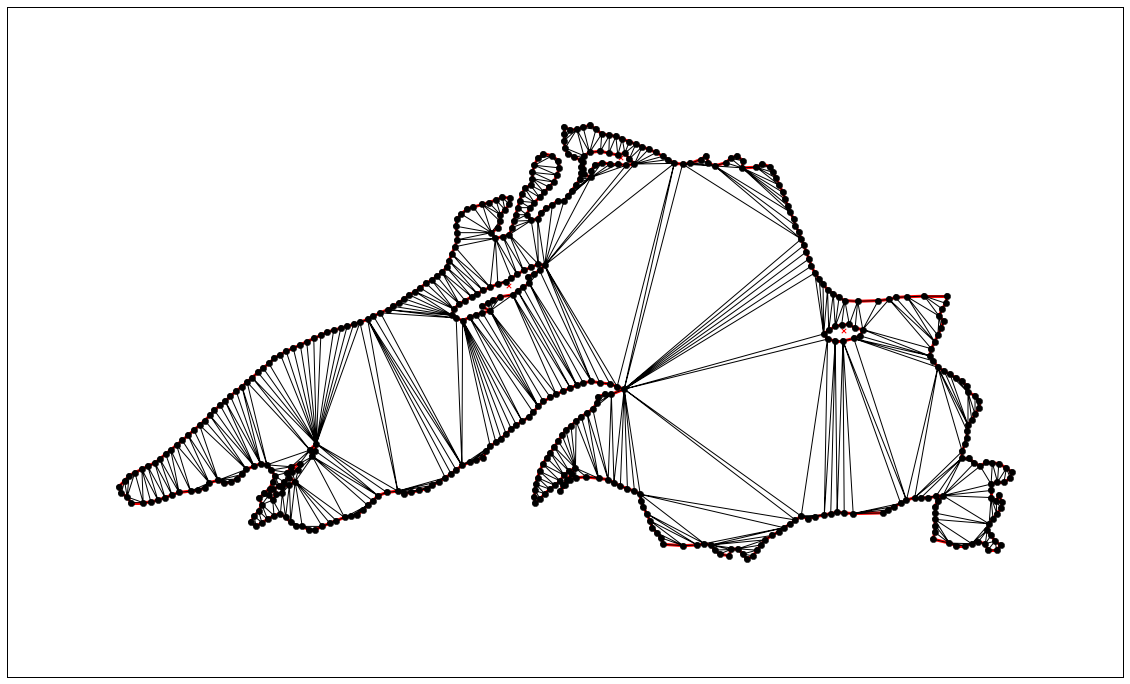

In [13]:
from triangle import triangulate, plot as tplot

cndt = triangulate(lake_superior, 'p')

plt.figure(figsize=(24,12))
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax, **cndt)
plt.show()

Note the improvement with respect to the previous diagram, as well as the absence of triangles outside of the original polygon.

The next step is the computation of a conforming Delaunay triangulation (`cfdt`).  We enforce Steiner points on some segments to ensure as many Delaunay triangles as possible.  We achieve this with extra flag `D`.

In [14]:
cfdt = triangulate(lake_superior, 'pD')

But slight or no improvements with respect to the previous diagram can be observed in this case.  The real improvement arises when we further impose constraints in the values of minimum angles on triangles (with the flag `q`), or in the maximum values of the areas of triangles (with the flag 'a').  For instance, if we require a constrained conforming Delaunay triangulation (`cncfdt`) in which all triangles have a minimum angle of at least 20 degrees, we issue the following command

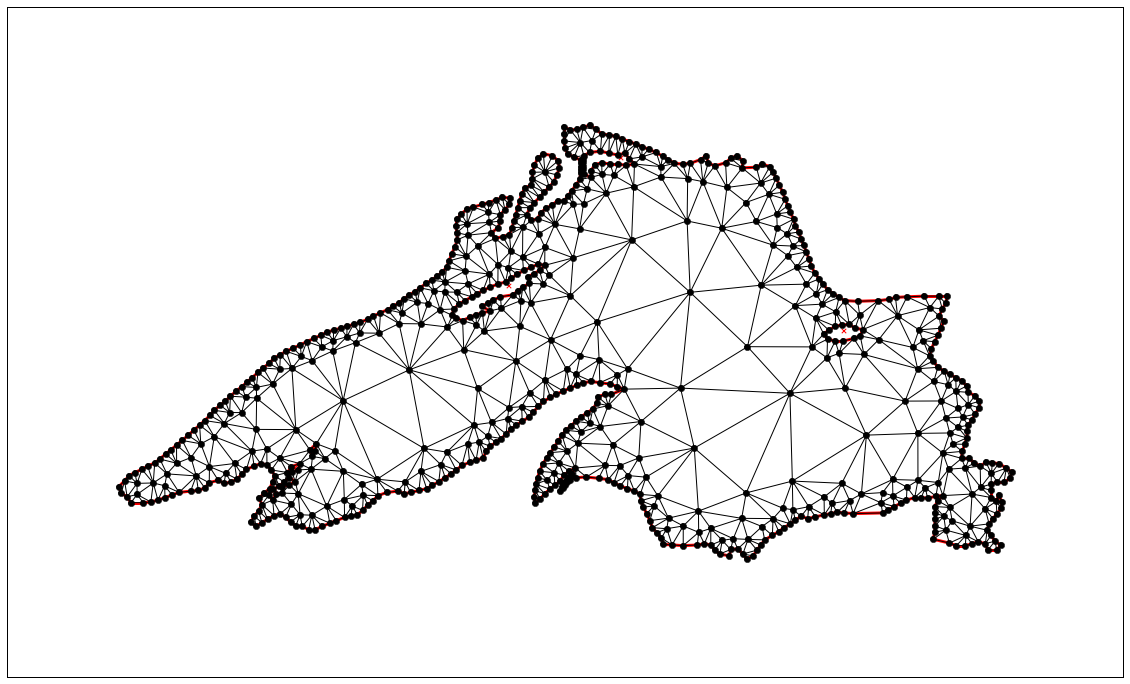

In [15]:
cncfq20dt = triangulate(lake_superior, 'pq20D')

plt.figure(figsize=(24,12))
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax, **cncfq20dt)
plt.show()

For the last example to conclude this section, we further impose a maximum area on triangles.  

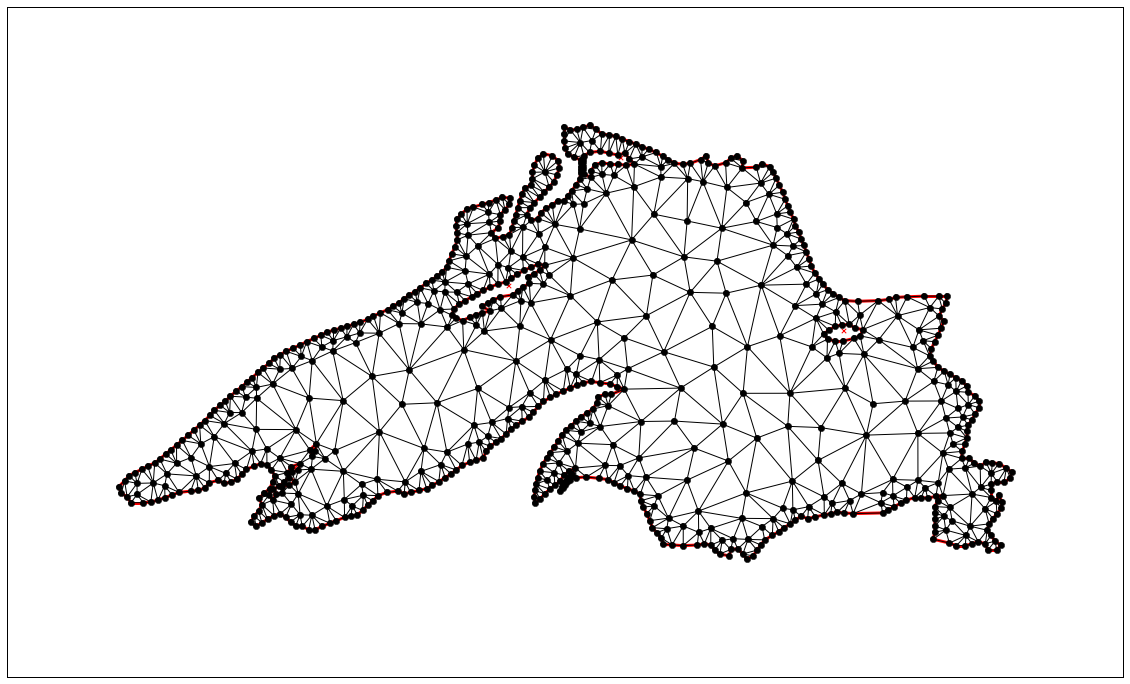

In [16]:
cncfq20adt = triangulate(lake_superior, 'pq20a.001D')

plt.figure(figsize=(24,12))
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax, **cncfq20adt)
plt.show()

##### Shortest Paths

We will use the last example to introduce a special setting of the problem of shortest paths.  We pick a location in the North-West coast of the lake (say, the vertex indexed as `370` in the original `poly` file), and the goal is to compute the shortest path to the furthest South-East location on the shore, at the bottom-right corner---this is the vertex indexed as `179` in the original `poly` file.   By a _path_ in this setting, we mean a chain of edges of the triangulation.

In the `scipy` stack we accomplish the computation of shortest paths on a triangulation (and in some other similar geometries that can be coded by means of graphs) by relying on two modules:

* `scipy.sparse` to store a weighted-adjacency matrix `G` representing the triangulation.  Each non-zero entry `G[i,j]` of this adjacency matrix is precisely the length of the edge from vertex `i` to vertex `j`.
* `scipy.sparse.csgraph`, the module that deals with *compressed sparse graphs*.  This module contains routines to analyze, extract information or manipulate graphs.  Among these routines, we have several different algorithms to compute shortest paths on a graph.


> For more information on the module `scipy.sparse.csgraph`, refer to the online documentation at docs.scipy.org/doc/scipy/reference/sparse.csgraph.html

> For the theory and applications of Graph Theory, one of the best sources is the introductory book by Reinhard Diestel, _Graph Theory_, published by Springer-Verlag.


Let us illustrate this example with proper code.  We start by collecting the indices of the vertices of all segments in the triangulation, and the lengths of these segments.


> To compute the length of each segment, rather than creating from scratch a routine that applies a reliable norm function over each item of the difference of two lists of related vertices, we use instead the function `minkowski_distance` from the module `scipy.spatial`.  

In [17]:
X = cncfq20adt['triangles'][:,0]
Y = cncfq20adt['triangles'][:,1]
Z = cncfq20adt['triangles'][:,2]

Xvert = [cncfq20adt['vertices'][x] for x in X]
Yvert = [cncfq20adt['vertices'][y] for y in Y]
Zvert = [cncfq20adt['vertices'][z] for z in Z]

from scipy.spatial import minkowski_distance

lengthsXY = minkowski_distance(Xvert, Yvert)
lengthsXZ = minkowski_distance(Xvert, Zvert)
lengthsYZ = minkowski_distance(Yvert, Zvert)

We now create the weighted-adjacency matrix, which we store as a `lil_matrix`, and compute the shortest path between the requested vertices.  We gather in a list all the vertices included in the computed path, and plot the resulting chain overlaid on the triangulation.

> A word of warning: the adjacency matrix we are about to compute is *not* the distance matrix.  In the distance matrix `A` we include on each entry `A[i, j]` the distance between vertex `i` to vertex `j` instead.  If this distance matrix is desired, the most reliable way to compute it is by means of the routine `distance_matrix` in the module `scipy.spatial`

>        >>> from scipy.spatial import distance_matrix
>        >>> A = distance_matrix(cncfq20adt['vertices'], cncfq20adt['vertices'])


In [18]:
from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import shortest_path

nvert = len(cncfq20adt['vertices'])
G = lil_matrix((nvert, nvert))

for k in range(len(X)):
    G[X[k], Y[k]] = G[Y[k], X[k]] = lengthsXY[k]
    G[X[k], Z[k]] = G[Z[k], X[k]] = lengthsXZ[k]
    G[Y[k], Z[k]] = G[Z[k], Y[k]] = lengthsYZ[k]
    
dist_matrix, pred = shortest_path(G, return_predecessors=True, directed=True, unweighted=False)

index = 370
path = [370]

while index != 197:
    index = pred[197, index]
    path.append(index)

print path

[370, 369, 629, 553, 358, 357, 680, 714, 469, 470, 632, 744, 764, 799, 800, 791, 790, 789, 801, 732, 725, 570, 647, 177, 178, 179, 180, 181, 182, 644, 571, 201, 200, 199, 197]


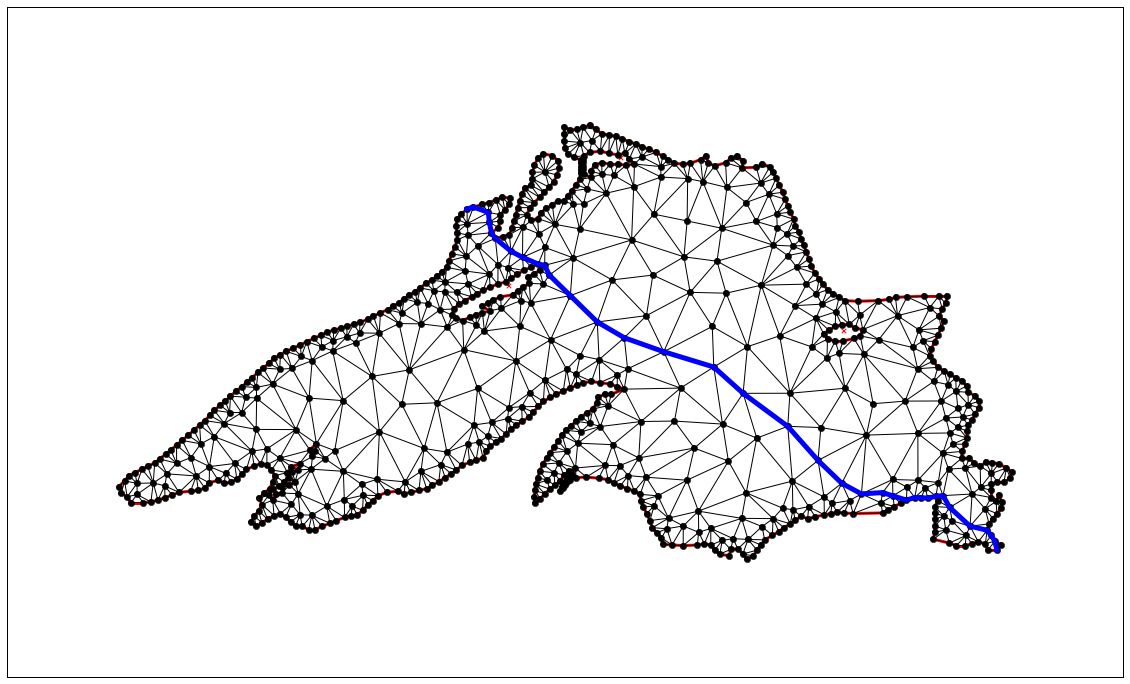

In [19]:
plt.figure(figsize=(24,12))
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax, **cncfq20adt)

Xs = [cncfq20adt['vertices'][x][0] for x in path]
Ys = [cncfq20adt['vertices'][x][1] for x in path]

ax.plot(Xs, Ys, '-', linewidth=5, color='blue')
plt.show()